In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from gymnasium.envs.toy_text.blackjack import BlackjackEnv
from pathlib import Path


In [121]:
import numpy as np
from collections import defaultdict
from blackjack.blackjack_util import get_sorted_keys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns


def get_policy_grid(policy_mdp, values, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    policy = defaultdict(int)
    state_value = defaultdict(int)
    state_idx_mapping = get_sorted_keys()
    for idx, action in enumerate(policy_mdp[:280]):
        policy[tuple(state_idx_mapping[idx])] = action

    for idx, action in enumerate(values[:280]):
        state_value[tuple(state_idx_mapping[idx])] = action

    # for obs, action_values in agent.q_values.items():
    #     state_value[obs] = float(np.max(action_values))
    #     policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return policy_grid, value_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

In [6]:
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from gymnasium import Env

from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv
from gym_to_mdp import GymToMDPConverter
from tqdm import tqdm

RENDER_MODE = 'rgb_array'  # 'human'
RENDER = False
SEED = 101
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


# def play_using_policy(env, policy, games=100, max_tries=1000):
#     """Simulate a gameplay using the policy"""
#     rewards_queue = []
#     for _ in tqdm(range(games)):
#         # print('playing')
#         obs, info = env.reset()
#         done = False

#         # play one episode
#         count = 0
#         while not done:
#             action = policy[obs]
#             next_obs, reward, terminated, truncated, info = env.step(action)
#             # update if the environment is done and the current obs
#             # print(f"next_obs = {next_obs} ; action = {action}")
#             done = terminated or truncated
#             obs = next_obs
#             count += 1
#             if done:
#                 rewards_queue.append(reward)
#             if count > max_tries:
#                 rewards_queue.append('T')
#                 break
#     return rewards_queue

def play_blackjack(env, policy, games=200, max_tries=5000, log=True):
    """Simulate a gameplay using the policy"""
    rewards_queue = []
    for _ in tqdm(range(games)):
        # print('playing')
        obs, info = env.reset()
        done = False

        # play one episode
        count = 0
        while not done:
            action = policy[obs]
            next_obs, reward, terminated, truncated, info = env.step(action)
            # update if the environment is done and the current obs
            # print(f"next_obs = {next_obs} ; action = {action}")
            done = terminated or truncated
            obs = next_obs
            count += 1
            if done:
                rewards_queue.append(reward)
            if count > max_tries:
                rewards_queue.append('T')
                break
    success_pct = (rewards_queue.count(1) / games) * 100
    not_finish_pct = (rewards_queue.count('T') / games) * 100
    if log:
        print(f'Success % => {success_pct} %')
        print(f"Didn't finish % => {not_finish_pct} %")
    return rewards_queue, success_pct, not_finish_pct

In [7]:
GAMMAS = [0.7, 0.8, 0.95, 0.99]

In [9]:
VI_stats_dict = {}
for gamma in GAMMAS:
    VI_stats_dict[gamma] = pd.read_csv(f"blackjack/vi_stats/_algo=VI_prob=BlackJack_gamma={gamma}_epsilon=1e-15_.csv")

In [14]:
VI_stats_dict[0.99].tail()

,Unnamed: 0,State,Action,Reward,Error,Time,Max V,Mean V,Iteration
9,9,NaN,NaN,0.99381,4.775615e-09,0.001471,0.99381,0.056115,10
10,10,NaN,NaN,0.99381,1.149313e-10,0.001644,0.99381,0.056115,11
11,11,NaN,NaN,0.99381,1.605610e-12,0.001910,0.99381,0.056115,12
12,12,NaN,NaN,0.99381,9.740472e-15,0.002131,0.99381,0.056115,13
13,13,NaN,NaN,0.99381,0.000000e+00,0.002332,0.99381,0.056115,14


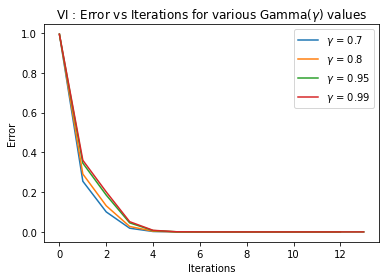

In [36]:
# plt.figure(figsize=(10, 6))
for gamma in GAMMAS:
    reward = VI_stats_dict[gamma]['Error']
    plt.plot(np.arange(reward.shape[0]), reward, label=f'$\gamma$ = {gamma}')
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.title('VI : Error vs Iterations for various Gamma($\gamma$) values')
    plt.legend()

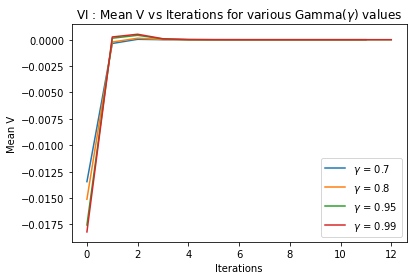

In [35]:
# df.currentPrice.diff().shift(-1)
# plt.figure(figsize=(10, 6))
for gamma in GAMMAS:
    reward = VI_stats_dict[gamma]['Mean V'].diff().shift(-1)
    plt.plot(np.arange(reward.shape[0]), reward, label=f'$\gamma$ = {gamma}')
    plt.ylabel('Mean V')
    plt.xlabel('Iterations')
    plt.title('VI : Mean V vs Iterations for various Gamma($\gamma$) values')
    plt.legend()

In [29]:
VI_policies_for_gamma = [
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 1,
     3, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0],
    [0, 0, 0, 2, 2, 2, 1, 1, 0, 3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 1,
     3, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0],
    [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 1,
     3, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0],
    [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 0, 0, 0, 0, 2, 1, 3, 3, 3, 0, 2, 1,
     3, 2, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0]]

In [17]:
# succss_pcts = []
# for idx, gamma in enumerate(GAMMAS):
#     game_res = play_using_policy(FL_env, VI_policies_for_gamma[idx])
#     # success_percent = game_res.count(1)
#     succss_pcts.append(game_res)

In [18]:
# succss_pcts[3].count('T')

In [63]:
# res = play_using_policy(FL_env, policies_for_gamma[1])
# res.count(1)

In [64]:
# plt.bar([f'$\gamma$={gamma}' for gamma in GAMMAS], reward)
# plt.ylabel('Success %')
# plt.xlabel('Gamma Values')
# plt.title('VI learned policy Success % with various Gamma($\gamma$) values')
# plt.legend()

# Policy Iteation

In [19]:
PI_stats_dict = {}
for gamma in GAMMAS:
    PI_stats_dict[gamma] = pd.read_csv(f"blackjack/pi_stats/_algo=PI_prob=BlackJack_gamma={gamma}_.csv")

In [21]:
PI_stats_dict[0.7].head()

,Unnamed: 0,State,Action,Reward,Error,Time,Max V,Mean V,Iteration
0,0,NaN,NaN,0.99381,8.686334e-02,0.008320,0.99381,0.056895,1
1,1,NaN,NaN,0.99381,2.220446e-16,0.011072,0.99381,0.059677,2


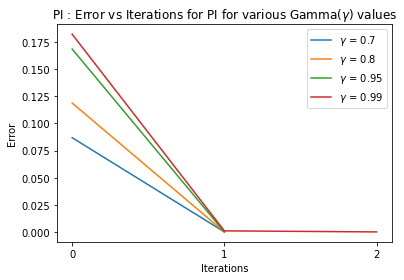

In [34]:
# plt.figure(figsize=(10, 6))
for gamma in GAMMAS:
    reward = PI_stats_dict[gamma]['Error']  #stats_dict[gamma]['Reward'].diff().shift(-1)
    plt.plot(np.arange(reward.shape[0]), reward, label=f'$\gamma$ = {gamma}')
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.xticks(np.arange(reward.shape[0]))
    plt.title('PI : Error vs Iterations for PI for various Gamma($\gamma$) values')
    plt.legend()

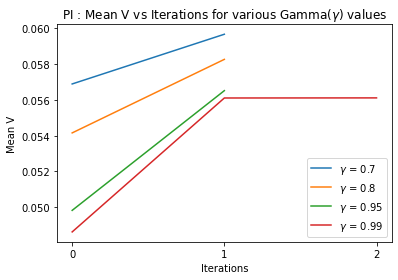

In [33]:
# plt.figure(figsize=(10, 6))
for gamma in GAMMAS:
    reward = PI_stats_dict[gamma]['Mean V']
    plt.plot(np.arange(reward.shape[0]), reward, label=f'$\gamma$ = {gamma}')
    plt.ylabel('Mean V')
    plt.xlabel('Iterations')
    plt.xticks(np.arange(reward.shape[0]))
    plt.title('PI : Mean V vs Iterations for various Gamma($\gamma$) values')
    plt.legend()

In [159]:
# Policies
PI_policies_for_gamma = [
    [2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 1,
     3, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0],
    [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 2, 1, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 1,
     3, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0],
    [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 1,
     3, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0],
    [2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 0, 0, 0, 0, 2, 1, 3, 3, 3, 0, 2, 1,
     3, 2, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0]
]

In [26]:
# succss_pcts = []
# for idx, gamma in enumerate(GAMMAS):
#     game_res = play_using_policy(FL_env, PI_policies_for_gamma[idx])
#     # success_percent = game_res.count(1)
#     succss_pcts.append(game_res)
#     print(f'gamma = {gamma}, success = {game_res.count(1) / 500}, stuck = {game_res.count("T")}')

In [152]:
PI_stats_dict[0.99].tail()

,Unnamed: 0,State,Action,Reward,Error,Time,Max V,Mean V,Iteration
2,2,NaN,NaN,0.818263,2.031710e-01,0.001191,0.818263,-0.009960,3
3,3,NaN,NaN,0.859552,9.624458e-02,0.001668,0.859552,0.049191,4
4,4,NaN,NaN,0.869936,3.950267e-02,0.002339,0.869936,0.232618,5
5,5,NaN,NaN,0.870576,4.086811e-03,0.002871,0.870576,0.267994,6
6,6,NaN,NaN,0.870582,1.665335e-16,0.003284,0.870582,0.269233,7


In [153]:
VI_stats_dict[0.99].tail()

,Unnamed: 0,State,Action,Reward,Error,Time,Max V,Mean V,Iteration
121,121,NaN,NaN,0.869190,0.001155,0.002770,0.869190,0.262529,122
122,122,NaN,NaN,0.869248,0.001113,0.002798,0.869248,0.262795,123
123,123,NaN,NaN,0.869303,0.001073,0.002822,0.869303,0.263051,124
124,124,NaN,NaN,0.869356,0.001033,0.002845,0.869356,0.263297,125
125,125,NaN,NaN,0.869407,0.000995,0.002868,0.869407,0.263533,126


In [96]:
.999 ** 10000

4.517334597704824e-05

# Q-Learning

In [99]:
LR = [0.5, 0.1, 0.01, 0.001]
DECAY = ['exp', 'linear']
QL_stats_dict = {}
gamma = 0.99
for lr in LR:
    for decay in DECAY:
        QL_stats_dict[(lr, decay)] = json.loads(Path(f"blackjack/ql_stats/Blackjack-lr_{lr}-gamma_{gamma}-decay_{decay}.json").read_text())

In [100]:
# fl_env = get_frozen_lake_env()[0]

In [101]:
QL_stats_dict.keys()

dict_keys([(0.5, 'exp'), (0.5, 'linear'), (0.1, 'exp'), (0.1, 'linear'), (0.01, 'exp'), (0.01, 'linear'), (0.001, 'exp'), (0.001, 'linear')])

In [102]:
QL_stats_dict[(0.5, 'exp')].keys()

dict_keys(['Episodes', 'Params', 'Policy', 'Time', 'Reward Queue', 'Episode_Length Queue', 'Training Error', 'Time Delta'])

In [103]:
from enum import Enum

class StatKeysEnum(Enum):
    Episodes=  'Episodes'
    Params = 'Params'
    Policy = 'Policy'
    Time = 'Time'
    RewardQueue = 'Reward Queue'
    EpisodeQueue = 'Episode_Length Queue'
    TrainingError = 'Training Error'
    TimeDelta = 'Time Delta'

In [104]:
# def load_as_list(stats_df, column_name):
#     return json.loads(stats_df.at[0, column_name])

In [105]:
def get_moving_avg(samples, rolling_length=500):
    return (np.convolve(
        np.array(samples).flatten(), np.ones(rolling_length), mode="valid"
    ) / rolling_length)

In [106]:
# reward_moving_average = (
#         np.convolve(
#             np.array(reward_queue).flatten(), np.ones(rolling_length), mode="valid"
#         )
#         / rolling_length
# )
from typing import List
from matplotlib.axes import Axes
from matplotlib.figure import Figure

Text(0.5, 0, 'Iterations')

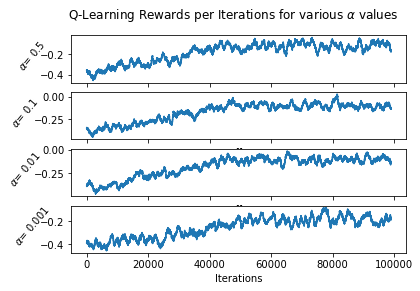

In [107]:
# Rewards
fig, axes = plt.subplots(4, 1, sharex='all')
fig: Figure
axes: List[Axes]
plt.suptitle(r'Q-Learning Rewards per Iterations for various $\alpha$ values')
for i, lr in enumerate(LR):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, 'linear')][StatKeysEnum.RewardQueue.value], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'$\alpha$= {lr}', rotation=50)
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

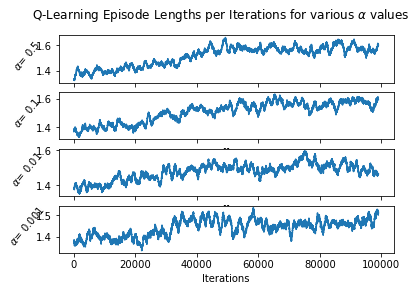

In [108]:
# Episode Lengths
fig, axes = plt.subplots(4, 1, sharex='all')
fig: Figure
axes: List[Axes]
plt.suptitle(r'Q-Learning Episode Lengths per Iterations for various $\alpha$ values')
for i, lr in enumerate(LR):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, 'linear')][StatKeysEnum.EpisodeQueue.value], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'$\alpha$= {lr}', rotation=50)
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

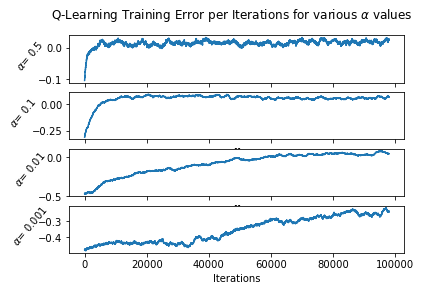

In [110]:
# Training Error
fig, axes = plt.subplots(4, 1, sharex='all')
fig: Figure
axes: List[Axes]
plt.suptitle(r'Q-Learning Training Error per Iterations for various $\alpha$ values')
for i, lr in enumerate(LR):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, 'linear')][StatKeysEnum.TrainingError.value][:100000], rolling_length=2000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'$\alpha$= {lr}', rotation=50)
plt.xlabel('Iterations')

In [57]:
# Play using a certain policy
# policy = json.loads(al_stats_dict[0.01].at[0, 'Policy'])
# res = play_using_policy(fl_env, policy, games=200)

In [58]:
# LR = [0.5, 0.1, 0.01, 0.001]
# DECAY = ['exp', 'linear']
# FL_env = get_frozen_lake_env()[0]
# for lr in LR:
#     for decay in DECAY:
#         policy = json.loads(QL_stats_dict[(lr, decay)].at[0, 'Policy'])
#         print(f'\n********************************** For LR {lr} & decay {decay} **********************************')
#         res = play_using_policy(FL_env, policy, games=200)

## Plot for best decay

Text(0.5, 0, 'Iterations')

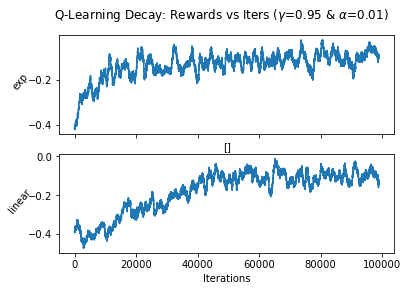

In [111]:
# Rewards
fig, axes = plt.subplots(2, 1, sharex='all')
fig: Figure
axes: List[Axes]
plt.suptitle(r'Q-Learning Decay: Rewards vs Iters ($\gamma$=0.95 & $\alpha$=0.01)')
lr = 0.01
for i, decay in enumerate(DECAY):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, decay)][StatKeysEnum.RewardQueue.value], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'{decay}', rotation=50)
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

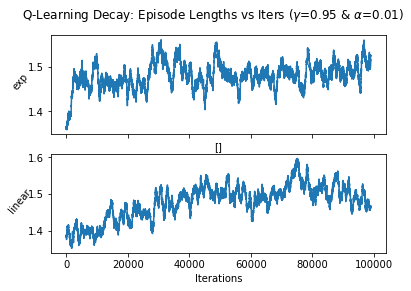

In [112]:
# Episode Lengths
fig, axes = plt.subplots(2, 1, sharex='all')
fig: Figure
axes: List[Axes]
plt.suptitle(r'Q-Learning Decay: Episode Lengths vs Iters ($\gamma$=0.95 & $\alpha$=0.01)')
for i, decay in enumerate(DECAY):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, decay)][StatKeysEnum.EpisodeQueue.value], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'{decay}', rotation=50)
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

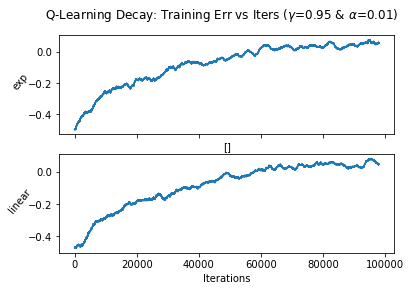

In [113]:
# Training Error
fig, axes = plt.subplots(2, 1, sharex='all')
fig: Figure
axes: List[Axes]
plt.suptitle(r'Q-Learning Decay: Training Err vs Iters ($\gamma$=0.95 & $\alpha$=0.01)')
for i, decay in enumerate(DECAY):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, decay)][StatKeysEnum.TrainingError.value][:100000], rolling_length=2000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'{decay}', rotation=50)
plt.xlabel('Iterations')

In [85]:
print(QL_stats_dict.keys())

dict_keys([(0.5, 'exp'), (0.5, 'linear'), (0.1, 'exp'), (0.1, 'linear'), (0.01, 'exp'), (0.01, 'linear'), (0.001, 'exp'), (0.001, 'linear')])


## Gamma values

In [114]:
LR = [0.1]
DECAY = ['linear']
GAMMAS = [0.7, 0.8, 0.95, 0.99]
for lr in LR:
    for decay in DECAY:
        for gamma in GAMMAS:
            QL_stats_dict[(lr, decay, gamma)] = json.loads(Path(f"blackjack/ql_stats/Blackjack-lr_{lr}-gamma_{gamma}-decay_{decay}.json").read_text())

Text(0.5, 0, 'Iterations')

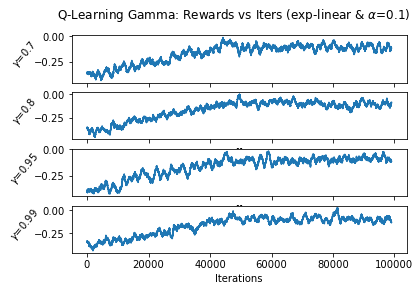

In [120]:
# Rewards
fig, axes = plt.subplots(4, 1, sharex='all')
fig: Figure
axes: List[Axes]
lr = 0.1
decay = 'linear'
plt.suptitle(fr'Q-Learning Gamma: Rewards vs Iters (exp-{decay} & $\alpha$={lr})')
for i, gamma in enumerate(GAMMAS):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, decay, gamma)][StatKeysEnum.RewardQueue.value], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'$\gamma$={gamma}', rotation=50)
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

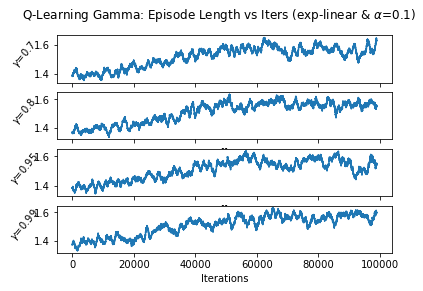

In [116]:
fig, axes = plt.subplots(4, 1, sharex='all')
fig: Figure
axes: List[Axes]
lr = 0.1
decay = 'linear'
plt.suptitle(fr'Q-Learning Gamma: Episode Length vs Iters (exp-{decay} & $\alpha$={lr})')
for i, gamma in enumerate(GAMMAS):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, decay, gamma)][StatKeysEnum.EpisodeQueue.value], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'$\gamma$={gamma}', rotation=50)
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

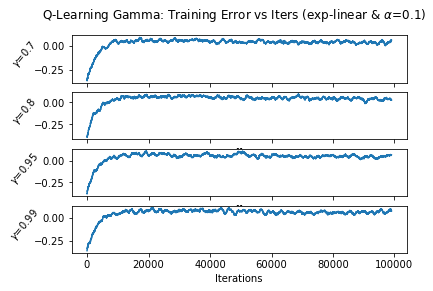

In [119]:
fig, axes = plt.subplots(4, 1, sharex='all')
fig: Figure
axes: List[Axes]
lr = 0.1
decay = 'linear'
plt.suptitle(fr'Q-Learning Gamma: Training Error vs Iters (exp-{decay} & $\alpha$={lr})')
for i, gamma in enumerate(GAMMAS):
    rewards_mov_avg = get_moving_avg(QL_stats_dict[(lr, decay, gamma)][StatKeysEnum.TrainingError.value][:100000], rolling_length=1000)
    axes[i].plot(rewards_mov_avg)
    axes[i].set_xlabel([])
    axes[i].set_ylabel(fr'$\gamma$={gamma}', rotation=50)
plt.xlabel('Iterations')

In [97]:
# LR = [0.01]
# DECAY = ['exp']
# FL_env = get_frozen_lake_env()[0]
# for gamma in GAMMAS:
#     for decay in DECAY:
#         policy = json.loads(QL_stats_dict[(lr, decay, gamma)].at[0, 'Policy'])
#         print(f'\n********************************** For LR {lr} & decay {decay} **********************************')
#         res = play_using_policy(FL_env, policy, games=200)